In [1]:
# PROJECT/IMPLEMENTATION IDEAS
# 1. Historical market cap, % bitcoin (requires crawling https://coinmarketcap.com/historical/)
# 2. Twitter sentiment analysis of Bitcoin vs price
# 3. Bitcoin vs. altcoin market caps
# 4. Transaction fees, user/address count(?), other features(?) vs bitcoin price
# 5. Usage by country
# 6. Bitcoin trading by exchange
# 7. Bitcoin trading by currency
# 8. Increase in leverage?

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from pandas.core import datetools
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import dateutil.parser
from pprint import pprint
import warnings; warnings.simplefilter('ignore')
import json
import time
import sys
import re
import datetime

# APIs
# import quandl
# import coinmarketcap

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Helper functions
def to_currency(int):
    return "${:,.0f}".format(int//1000000)

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

def list_to_average(list):
    try:
        avg = list[0]/list[1]
    except:
        avg = 0
    return avg

# def none_to_value(num):
#     if num == None:
#         num = 


In [4]:
df = pd.read_pickle('data/benson_btcsentiment_df.pkl')
df = df[['logBTCPrice','logETHPrice','logBTCVol','logTxFees','logCostperTxn','logNoTxns','logAvgBlkSz','logUniqueAddresses','logHashRate','logCrypto Market Cap','logNasdaq','logGold','logInterest','DateNum']]
df_all = df
df_hist = df
df.head()

,logBTCPrice,logETHPrice,logBTCVol,logTxFees,logCostperTxn,logNoTxns,logAvgBlkSz,logUniqueAddresses,logHashRate,logCrypto Market Cap,logNasdaq,logGold,logInterest,DateNum
Date,,,,,,,,,,,,,,
2016-07-13,6.487181,2.356126,13.677656,10.454313,1.738710,12.296982,-0.261365,12.847761,14.232219,23.229166,8.518339,5.425787,1.098612,32.0
2016-07-14,6.486362,2.350422,13.679501,10.469753,1.621366,12.292677,-0.210721,12.813804,14.136909,23.229166,8.523982,5.424421,1.098612,33.0
2016-07-15,6.498043,2.442347,13.536535,10.561370,1.702928,12.304356,-0.235722,12.815710,14.225202,23.229166,8.523094,5.411646,1.098612,34.0
2016-07-17,6.498043,2.442347,13.536535,10.561370,1.702928,12.304356,-0.235722,12.815710,14.225202,23.279152,8.523094,5.411646,1.098612,34.0
2016-07-18,6.522313,2.429218,13.531194,10.390760,2.026832,12.049495,-0.356675,12.707847,14.273321,23.279152,8.528287,5.413564,1.098612,35.0


In [5]:
df_all.corr().sort_values('logBTCPrice')

,logBTCPrice,logETHPrice,logBTCVol,logTxFees,logCostperTxn,logNoTxns,logAvgBlkSz,logUniqueAddresses,logHashRate,logCrypto Market Cap,logNasdaq,logGold,logInterest,DateNum
logBTCVol,-0.431239,-0.568530,1.000000,-0.469858,-0.459423,0.005063,-0.238120,-0.205965,-0.488441,-0.471979,-0.540264,-0.139843,-0.388434,-0.490404
logGold,-0.300239,-0.234724,-0.139843,-0.347156,-0.249863,-0.385971,-0.374087,-0.430841,-0.349131,-0.272015,-0.350413,1.000000,-0.332429,-0.419522
logNoTxns,0.417669,0.267544,0.005063,0.502689,0.307579,1.000000,0.643794,0.863520,0.425767,0.352251,0.398531,-0.385971,0.463033,0.400896
logAvgBlkSz,0.577011,0.500506,-0.238120,0.680526,0.489047,0.643794,1.000000,0.705120,0.544873,0.549246,0.595868,-0.374087,0.598932,0.586728
logUniqueAddresses,0.774675,0.651851,-0.205965,0.824040,0.699790,0.863520,0.705120,1.000000,0.766314,0.728665,0.747720,-0.430841,0.792688,0.750534
logETHPrice,0.935958,1.000000,-0.568530,0.925093,0.949121,0.267544,0.500506,0.651851,0.928120,0.970024,0.942095,-0.234724,0.911239,0.936985
logNasdaq,0.958003,0.942095,-0.540264,0.950528,0.952240,0.398531,0.595868,0.747720,0.981777,0.963871,1.000000,-0.350413,0.941816,0.985475
logTxFees,0.958879,0.925093,-0.469858,1.000000,0.942124,0.502689,0.680526,0.824040,0.938114,0.957720,0.950528,-0.347156,0.953465,0.946283
DateNum,0.962805,0.936985,-0.490404,0.946283,0.953201,0.400896,0.586728,0.750534,0.983051,0.962697,0.985475,-0.419522,0.946026,1.000000
logHashRate,0.967681,0.928120,-0.488441,0.938114,0.965687,0.425767,0.544873,0.766314,1.000000,0.965703,0.981777,-0.349131,0.945228,0.983051


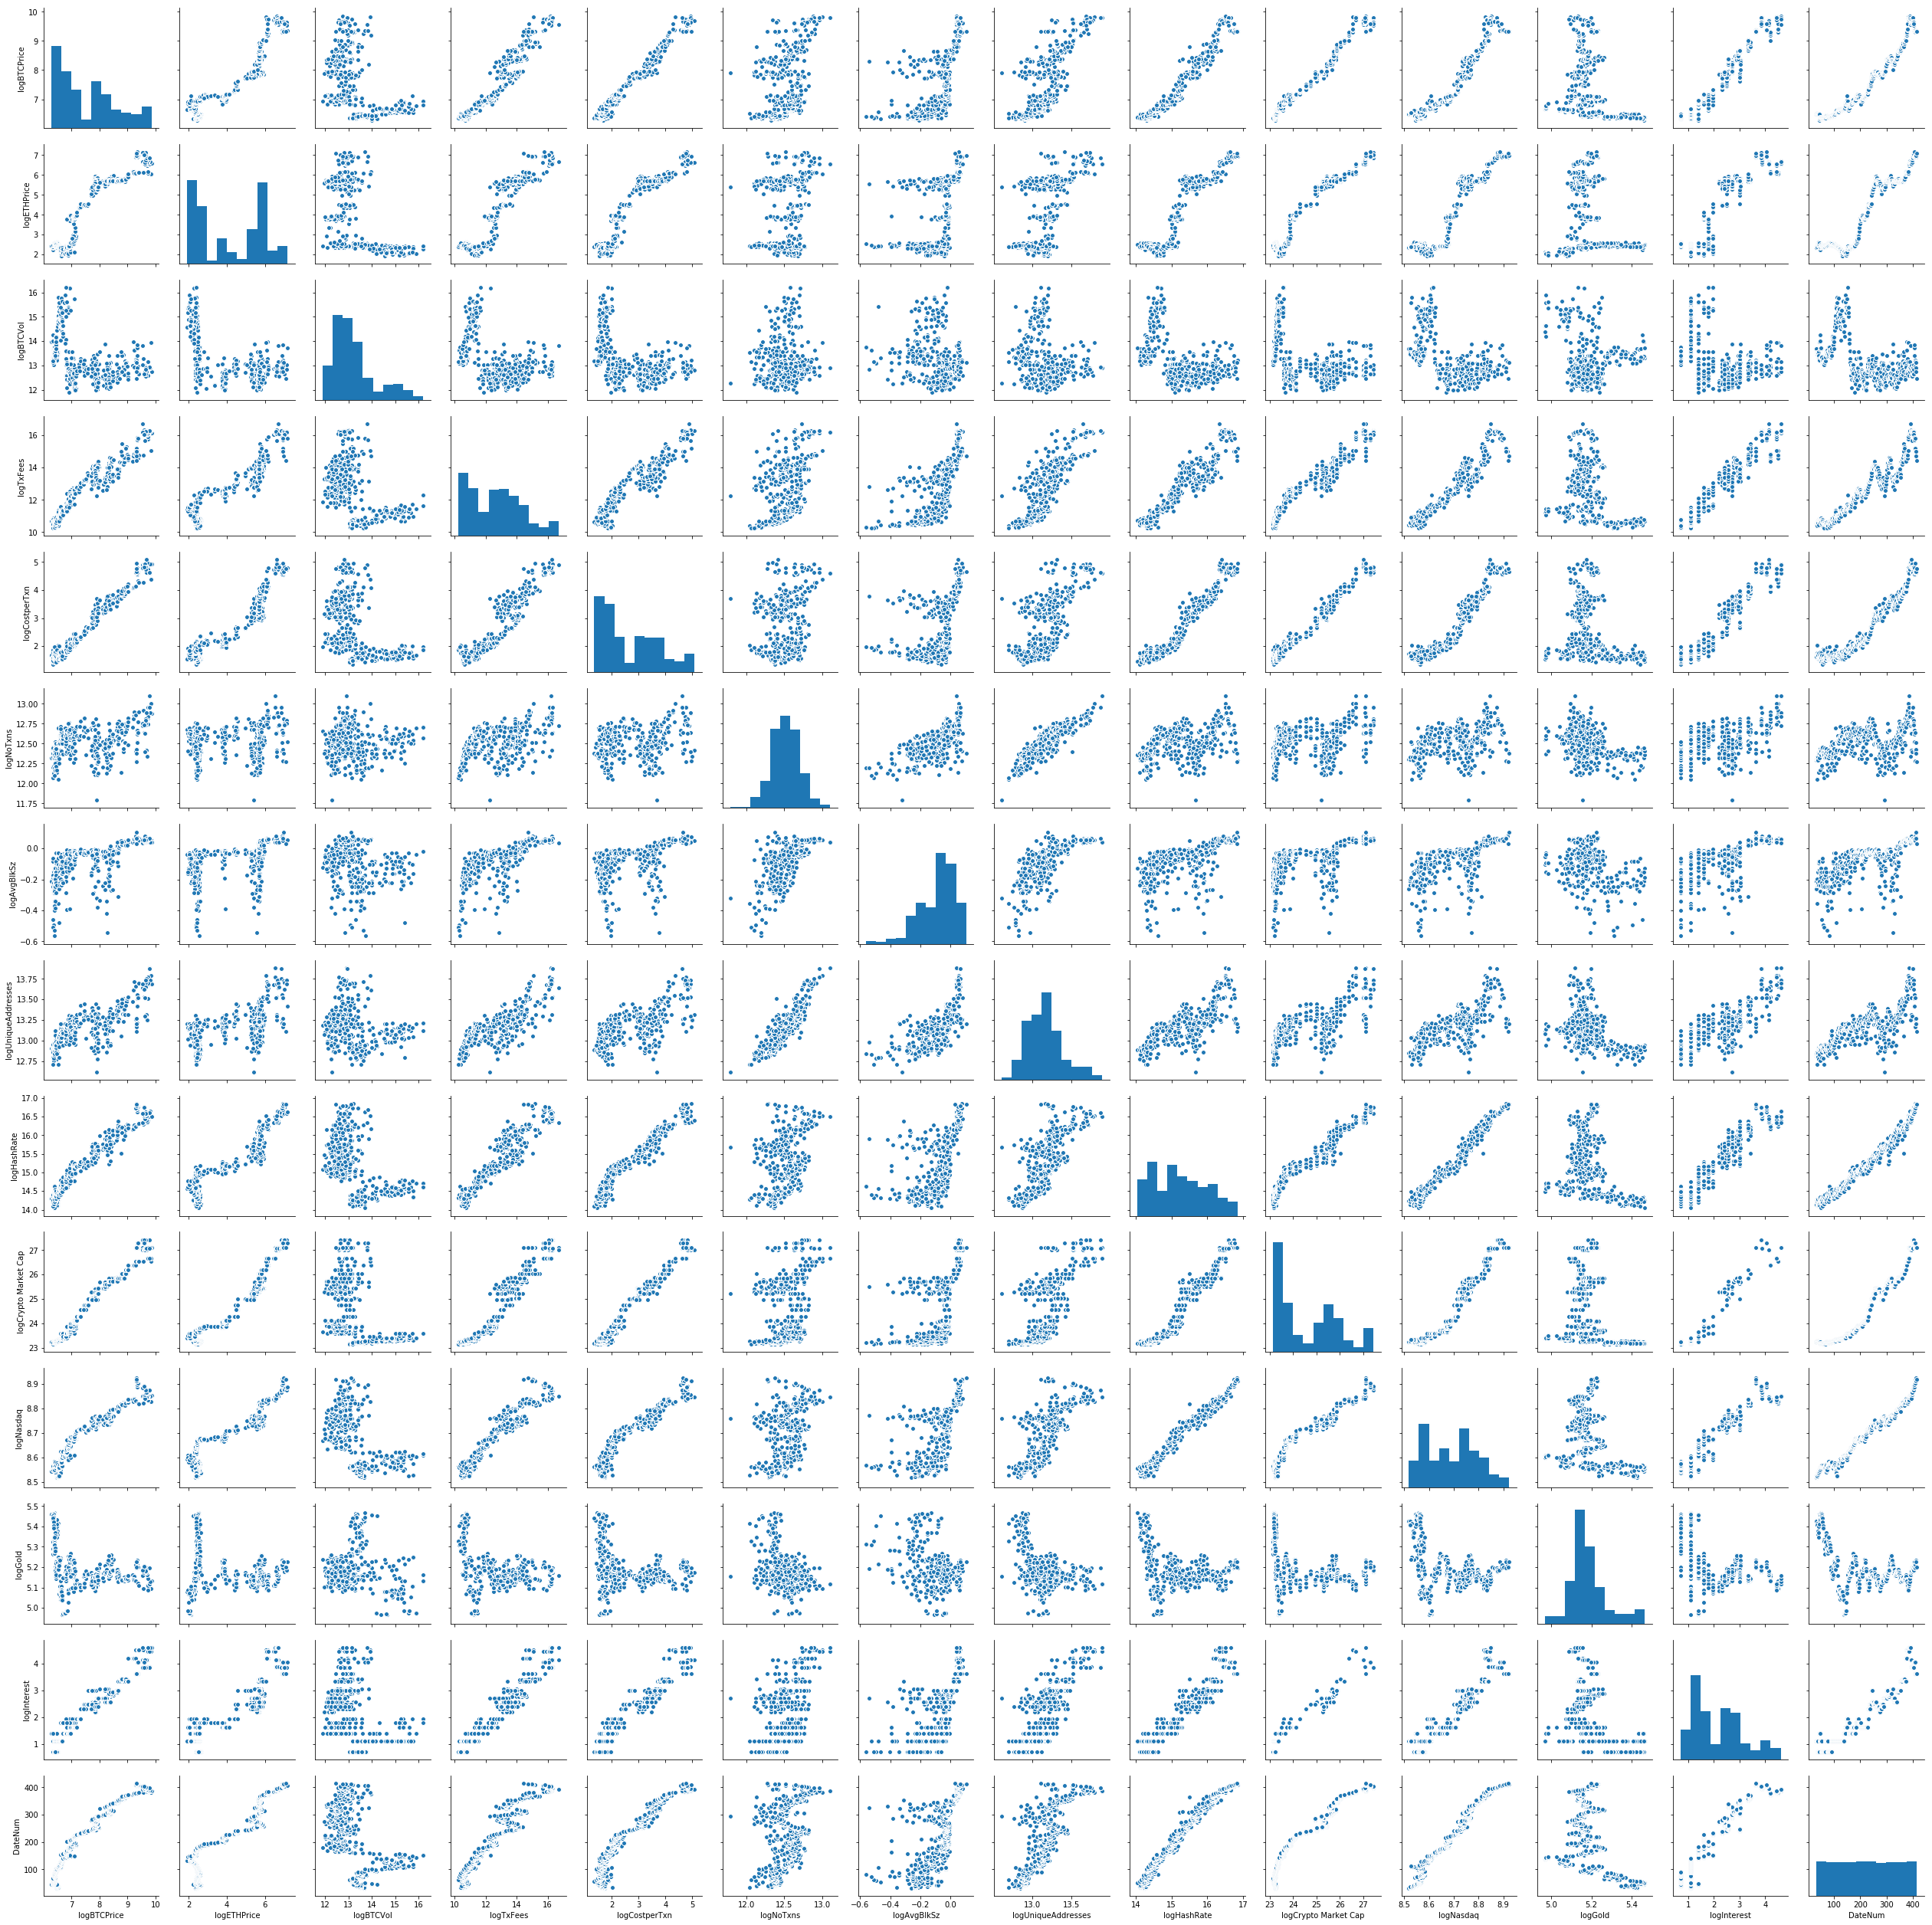

In [6]:
sns.pairplot(df_all)

In [7]:
# MAIN MODEL
# Reducing to few key features
df_all = df_all[['logBTCPrice','logNasdaq','logInterest','logTxFees']]
df_all.corr().sort_values('logBTCPrice')

,logBTCPrice,logNasdaq,logInterest,logTxFees
logNasdaq,0.958003,1.000000,0.941816,0.950528
logTxFees,0.958879,0.950528,0.953465,1.000000
logInterest,0.976921,0.941816,1.000000,0.953465
logBTCPrice,1.000000,0.958003,0.976921,0.958879


'\nPossible leading indicators:\nGoogle Search Interest\n\n\nFollowing Indicators:\nCost per Transaction\nCrypto Market Cap\nEthereum Price\n'

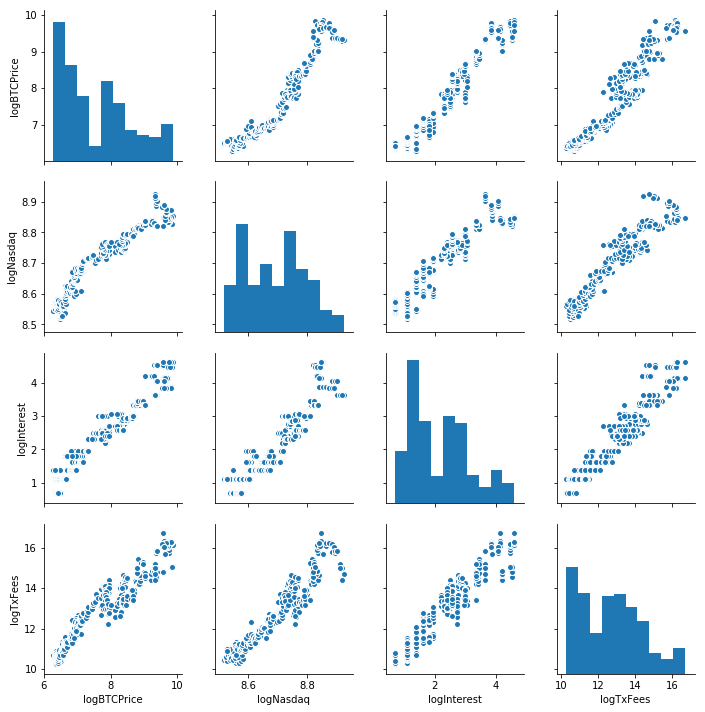

In [8]:
sns.pairplot(df_all)
'''
Possible leading indicators:
Google Search Interest


Following Indicators:
Cost per Transaction
Crypto Market Cap
Ethereum Price
'''

In [9]:
df = df_all
# STATSMODELS
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('logBTCPrice ~ logInterest + logNasdaq + logTxFees', data=df, return_type="dataframe")

# Create your model
model = sm.OLS(y,X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     4711.
Date:                Tue, 30 Jan 2018   Prob (F-statistic):               0.00
Time:                        18:16:24   Log-Likelihood:                 132.38
No. Observations:                 463   AIC:                            -256.8
Df Residuals:                     459   BIC:                            -240.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -17.9710      2.344     -7.668      0.000     -22.577     -13.365
logInterest     0.5772      0.029     19.711      0.000       0.520       0.635
logNasdaq       2.6618      0.287      9.278      0.000       2.098       3.226
logTxFees       0.0919      0.020      4.584      0.000       0.052       0.131
==============================================================================
Omnibus:                       13.208   Durbin-Watson:                   0.199
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.935
Skew:                          -0.419   Prob(JB):                     0.000942
Kurtosis:                       2.858   Cond. No.                     4.35e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

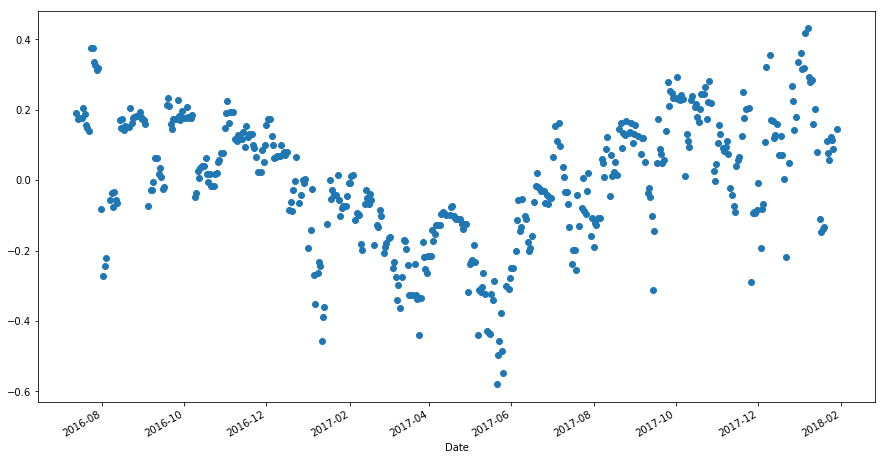

In [10]:
# Use statsmodels to plot the residuals
# NOTE THAT THIS IS A BAD FIT AS RESIDUALS ARE NOT RANDOM; NONLINEAR REGRESSION MAY BE REQUIRED
fit.resid.plot(style='o', figsize=(15,8));

In [13]:
# Histogram of residuals
# residuals = y - fit.predict(X)
# plt.hist(residuals, bins = 20, normed=True)

In [14]:
# Create an empty model
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X3 + X6 model
X = df[['logInterest','logNasdaq','logTxFees']]
# Choose the response variable(s)
y = df['logBTCPrice']
# Fit the model to the full dataset
lr.fit(X,y)
# Print out the R^2 for the model against the full dataset
print(lr.score(X,y))
print(lr.intercept_)
print(lr.coef_)

0.9685438898734812
-17.97102105541614
[0.57718673 2.66176741 0.09185837]


In [15]:
# The cross validation for a time series would be as follows:
# split = int(round(len(df) * 0.9,0))
# X_train, X_test, y_train, y_test = df.iloc[:split,1:], df.iloc[split:,1:],df.iloc[:split,0],df.iloc[split:,0]
# Due to project requirements, I am using the standard linear regression train-test split for this analysis.

In [16]:
from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size = 0.7)

# Fit the model against the training data
lr.fit(X_train, y_train)
# # Evaluate the model against the testing data
lr.score(X_test, y_test)

0.9700074658189736

In [17]:
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.9678549259469634
0.9700074658189736


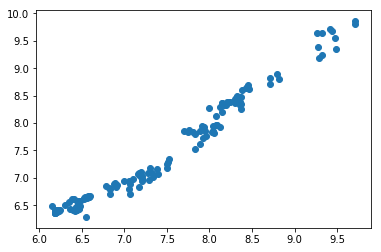

In [18]:
# chart prediction vs actual
plt.scatter(lr.predict(X_test), y_test)

In [19]:
model1 = sm.OLS(y_train, X_train, missing ='drop')
fit1 = model1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.550e+05
Date:                Tue, 30 Jan 2018   Prob (F-statistic):               0.00
Time:                        18:17:15   Log-Likelihood:                 60.178
No. Observations:                 324   AIC:                            -114.4
Df Residuals:                     321   BIC:                            -103.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
logInterest     0.6682      0.034     19.618      0.000       0.601       0.735
logNasdaq       0.4640      0.026     17.586      0.000       0.412       0.516
logTxFees       0.1653      0.023      7.079      0.000       0.119       0.211
==============================================================================
Omnibus:                       11.579   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.789
Skew:                          -0.443   Prob(JB):                      0.00275
Kurtosis:                       3.300   Cond. No.                         67.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
y_pred = fit1.predict(X_test)

Text(0,0.5,'Predicted y value')

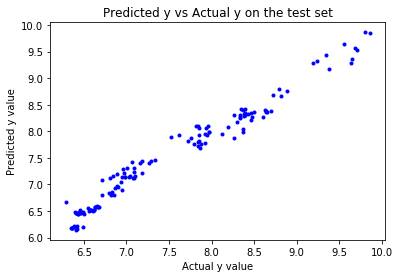

In [21]:
plt.plot(y_test, y_pred, 'b.')
plt.title('Predicted y vs Actual y on the test set')
plt.xlabel('Actual y value')
plt.ylabel('Predicted y value')

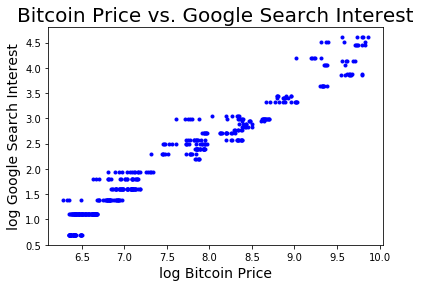

In [22]:
x = df['logBTCPrice']
y = df['logInterest']

plt.plot(x,y,'b.')
plt.title('Bitcoin Price vs. Google Search Interest',fontsize=20)
plt.xlabel('log Bitcoin Price',fontsize=14)
plt.ylabel('log Google Search Interest',fontsize=14)
plt.savefig('charts/interestvsbtcprice.png')

In [23]:
y, X = patsy.dmatrices('logBTCPrice ~ logInterest', data=df, return_type="dataframe")

# Create your model
model2 = sm.OLS(y,X)
# Fit your model to your training set
fit2 = model2.fit()
# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     9643.
Date:                Tue, 30 Jan 2018   Prob (F-statistic):          3.37e-311
Time:                        18:17:16   Log-Likelihood:                 46.288
No. Observations:                 463   AIC:                            -88.58
Df Residuals:                     461   BIC:                            -80.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.5065      0.023    236.676      0.000       5.461       5.552
logInterest     0.9640      0.010     98.199      0.000       0.945       0.983
==============================================================================
Omnibus:                       22.440   Durbin-Watson:                   0.259
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.987
Skew:                          -0.504   Prob(JB):                     3.75e-06
Kurtosis:                       3.530   Cond. No.                         6.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

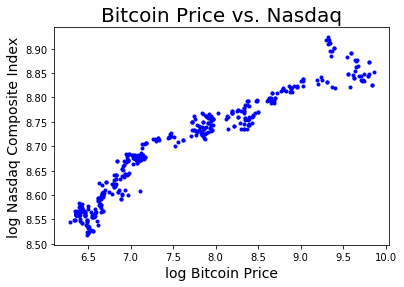

In [24]:
x = df['logBTCPrice']
y = df['logNasdaq']

plt.plot(x,y,'b.')
plt.title('Bitcoin Price vs. Nasdaq',fontsize=20)
plt.xlabel('log Bitcoin Price',fontsize=14)
plt.ylabel('log Nasdaq Composite Index',fontsize=14)
plt.savefig('charts/nasdaqvsbtcprice.png')

In [25]:
y, X = patsy.dmatrices('logBTCPrice ~ logNasdaq', data=df, return_type="dataframe")

# Create your model
model3 = sm.OLS(y,X)
# Fit your model to your training set
fit3 = model3.fit()
# Print summary statistics of the model's performance
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     5145.
Date:                Tue, 30 Jan 2018   Prob (F-statistic):          3.18e-252
Time:                        18:17:17   Log-Likelihood:                -90.077
No. Observations:                 463   AIC:                             184.2
Df Residuals:                     461   BIC:                             192.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -75.3836      1.156    -65.188      0.000     -77.656     -73.111
logNasdaq      9.5430      0.133     71.730      0.000       9.282       9.804
==============================================================================
Omnibus:                       21.858   Durbin-Watson:                   0.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.621
Skew:                           0.533   Prob(JB):                     7.42e-06
Kurtosis:                       3.297   Cond. No.                         744.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# Resources
# https://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/
# http://cs229.stanford.edu/proj2015/029_report.pdf
# http://text-processing.com/ API
# https://trends.google.com/trends/explore?q=bitcoin,ethereum